# House Rocket Sales 

## 0.0 IMPORTS


In [2]:
import pandas as pd
import numpy as np
import time
from multiprocessing import Pool
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib import pyplot as plt
from matplotlib import gridspec
from IPython.core.display import HTML
from geopy.geocoders import Nominatim
from IPython.core.display import HTML
import seaborn as sns
import warnings
import plotly.express as px
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 0.1 Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()


def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'
    
    

Populating the interactive namespace from numpy and matplotlib


C:\Users\fabic\Anaconda3\envs\houserocketsales\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['interactive']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [5]:
data = pd.read_csv('data/kc_house_data.csv')

# 1.0 DATA DESCRIPTION

In [6]:
df1 = data.copy()

## 1.1 Data Types and Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 21613
Number of columns: 21


In [8]:
df1.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

## 1.2 Check NA

In [9]:
df1.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 1.3 Change Data Types

In [10]:
# id, yr_built, yr_renovated, zipcode
df1[['id', 'waterfront', 'view', 'condition', 'yr_built', 'yr_renovated', 'zipcode']] = df1[['id', 'waterfront', 'view', 'condition', 'yr_built', 'yr_renovated', 'zipcode']].astype(str)

# lat, long
df1[['lat', 'long']] = df1[['lat', 'long']].astype(str)

# Date
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

id                       object
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront               object
view                     object
condition                object
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                 object
yr_renovated             object
zipcode                  object
lat                      object
long                     object
sqft_living15             int64
sqft_lot15                int64
dtype: object

## 1.4 Descriptive Statistics

In [11]:
# numerical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# categorical attributes
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.4.1 Numerical Attributes

In [12]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,75000.00,7700000.00,7625000.00,540088.14,450000.00,367118.70,4.02,34.59
1,bedrooms,0.00,33.00,33.00,3.37,3.00,0.93,1.97,49.06
2,bathrooms,0.00,8.00,8.00,2.11,2.25,0.77,0.51,1.28
3,sqft_living,290.00,13540.00,13250.00,2079.90,1910.00,918.42,1.47,5.24
4,sqft_lot,520.00,1651359.00,1650839.00,15106.97,7618.00,41419.55,13.06,285.08
5,floors,1.00,3.50,2.50,1.49,1.50,0.54,0.62,-0.48
6,grade,1.00,13.00,12.00,7.66,7.00,1.18,0.77,1.19
7,sqft_above,290.00,9410.00,9120.00,1788.39,1560.00,828.07,1.45,3.40
8,sqft_basement,0.00,4820.00,4820.00,291.51,0.00,442.56,1.58,2.72
9,sqft_living15,399.00,6210.00,5811.00,1986.55,1840.00,685.38,1.11,1.60


### 1.4.2 Categorical Attributes

In [13]:
cat_attributes.apply(lambda x: x.unique().shape[0])

id              21436
waterfront          2
view                5
condition           5
yr_built          116
yr_renovated       70
zipcode            70
lat              5034
long              752
dtype: int64

<AxesSubplot:xlabel='condition', ylabel='count'>

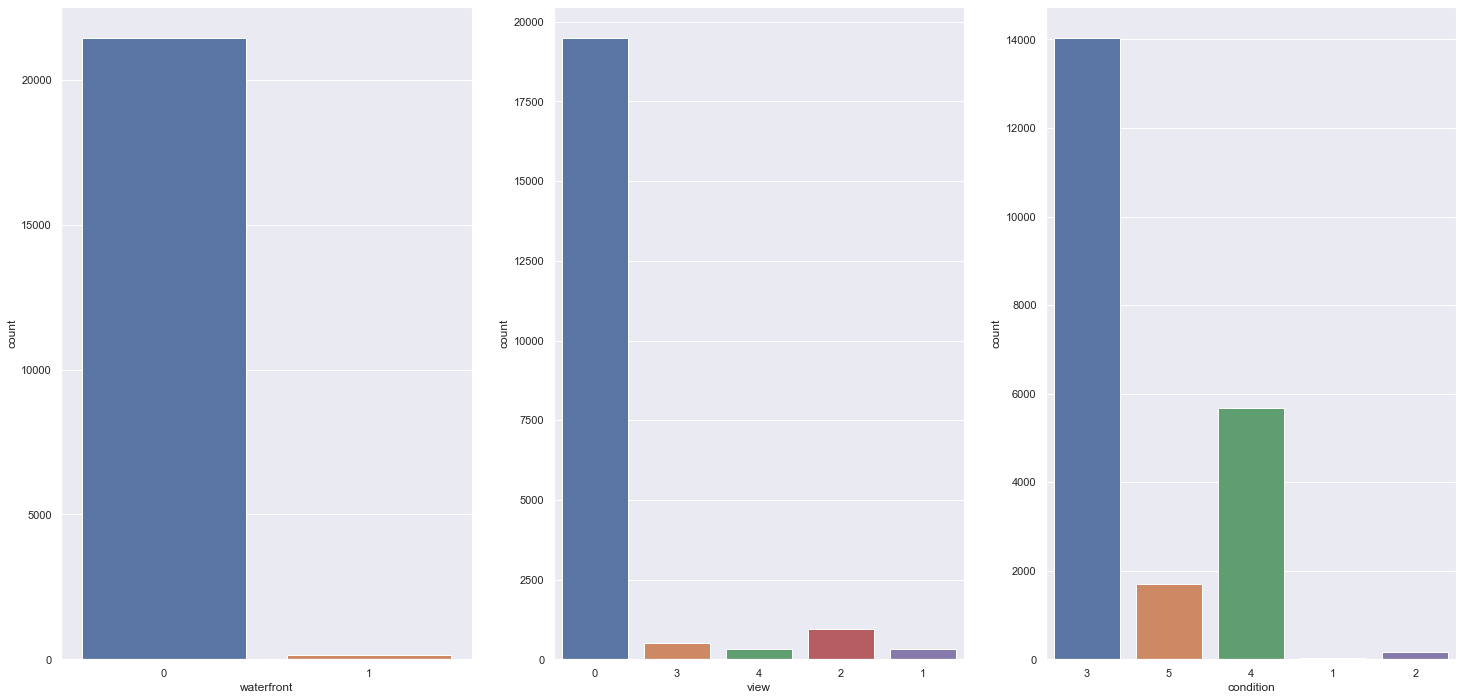

In [14]:
plt.subplot(1, 3, 1)
sns.countplot(df1['waterfront'])

plt.subplot(1, 3, 2)
sns.countplot(df1['view'])

plt.subplot(1, 3, 3)
sns.countplot(df1['condition'])

# 2.0 FEATURE ENGINEERING

In [15]:
df2 = df1.copy()

In [16]:
# Search for duplicates
print('Number of rows: {}'.format(df2.shape[0]))
print('Number of IDs: {}'.format(len(df2['id'].unique())))

Number of rows: 21613
Number of IDs: 21436


In [17]:
# Drop duplicate ID's
df2 = df2.drop_duplicates(subset = ['id'], keep = 'last')

In [18]:
# Drop NA
df2 = df2.dropna()
df2 = df2.reset_index(drop=True)

In [19]:
# Watching for outliers

unique = df2[['bedrooms','bathrooms','floors','waterfront','view','condition','grade']]

for i in unique:
    print('Attribute: {} - {}'.format(i, df2[i].unique().tolist()))

Attribute: bedrooms - [3, 2, 4, 5, 1, 6, 7, 0, 8, 9, 11, 10, 33]
Attribute: bathrooms - [1.0, 2.25, 3.0, 2.0, 4.5, 1.5, 2.5, 1.75, 2.75, 3.25, 4.0, 3.5, 0.75, 4.75, 5.0, 4.25, 3.75, 0.0, 1.25, 5.25, 6.0, 0.5, 5.5, 6.75, 5.75, 8.0, 7.5, 7.75, 6.25, 6.5]
Attribute: floors - [1.0, 2.0, 1.5, 3.0, 2.5, 3.5]
Attribute: waterfront - ['0', '1']
Attribute: view - ['0', '3', '4', '2', '1']
Attribute: condition - ['3', '5', '4', '1', '2']
Attribute: grade - [7, 6, 8, 11, 9, 5, 10, 12, 4, 3, 13, 1]


In [20]:
# Removing outlier from 'bedrooms' column
df2.drop(df2.loc[df2['bedrooms'] == 33].index, inplace = True)

## Creating new features

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year-week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# house age
df2['house_age'] = 'NA'
df2.loc[df2['date'] > '2014-01-01', 'house_age'] = 'new_house'
df2.loc[df2['date'] < '2014-01-01', 'house_age'] = 'old_house'

# condition type
df2['condition'] = df2['condition'].astype(int64)
df2['condition_type'] = df2['condition'].apply(lambda x: 'bad' if x<=2 else 'regular' if (x==3)| (x==4) else 'good')

# Basement
df2['basement'] = df2['sqft_basement'].apply(lambda x: 'no' if x == 0 else 'yes')        

# Season
df2['season'] = df2['month'].apply(lambda x: 'summer' if (x > 5) & (x < 8)  else
                                             'spring' if (x > 2) & (x < 5)  else
                                             'fall'   if (x > 8) & (x < 12) else
                                             'winter')
# Renovated
df2['renovated'] = df2['yr_renovated'].apply(lambda x: 'no' if x == 0 else 'yes')

# Year of Construction
df2['yr_built'] = df2['yr_built'].astype(int64)
df2['construction'] = df2['yr_built'].apply(lambda x: '<1955' if x <= 1955 else '>1955')

# Describe condition
df2['describe_condition'] = df2['condition'].apply(lambda x: 'too bad' if x == 1 else
                                                             'bad'     if x == 2 else
                                                             'median'  if x == 3 else
                                                             'good'    if x == 4 else
                                                             'excellent')

In [22]:
# Describe price level
df2['price_level'] = 'NA'  
for i in range(len(df2)):
    if (df2.iloc[i, 2] > 0) & (df2.iloc[i, 2] < 321950):
        df2.loc[i, 'price_level'] = 0
    elif (df2.iloc[i, 2] >= 321950) & (df2.iloc[i, 2] < 450000):
        df2.loc[i, 'price_level'] = 1
    elif (df2.iloc[i, 2] >= 450000) & (df2.iloc[i, 2] < 645000):
        df2.loc[i, 'price_level'] = 2
    else:
        df2.loc[i, 'price_level'] = 3

In [23]:
# Describe standard (price < 540,000) and high standard (price > 540,000)
df2['standard'] = 'standard'  
for i in range(len(df2)):
    if (df2.iloc[i, 2] > 540000):
        df2.loc[i, 'standard'] = 'high_standard'

### Using API geolocator, add the following features to dataset:
- Place ID: property location identification
- OSM Type: Open Street Map type
- County: name of the county

In [24]:
df2['query'] = df2[['lat', 'long']].apply(lambda x: str(x['lat']) + ',' + str(x['long']), axis=1)

In [25]:
# As Jupyter Notebook doesn't run multi-thread parallelism processes, this function is saved in a separate file 
# and has been imported as a module in the next snippet. 

# def get_data(x):
#     index, row = x
#     time.sleep(1)
    
#     # API call
#     response = geolocator.reverse(row['query'])
    
#     place_id = response.raw['place_id']
#     osm_type = response.raw['osm_type']
#     county = response.raw['address']['county']
        
#     return place_id, osm_type, county

In [26]:
import defs

df_api = df2[['id', 'query']].sample(5).copy()

p = Pool(3)

start = time.process_time()
df_api[['place_id', 'osm_type', 'county']] = p.map(defs.get_data, df_api.iterrows())
end = time.process_time()

print('Time elapsed: {}'.format(end - start))

Time elapsed: 0.0


In [27]:
df_api.head(5).T

,19624,15294,10315,8959,12660
id,9272201704,3732800525,9264920270,7579200767,6979900330
query,"47.5874,-122.386","47.5569,-122.31","47.314,-122.344","47.5592,-122.385","47.6314,-121.968"
place_id,21798263,157544590,231389208,21242367,293827462
osm_type,node,way,way,node,way
county,King County,King County,King County,King County,King County


# 3.0 EDA - Exploratory Data Analysis

In [28]:
df3 = df2.copy()

## 3.1 Hipothesis & Insights

### H1: Average price of properties with water view would be 50% more expensive

<AxesSubplot:xlabel='waterfront', ylabel='price'>

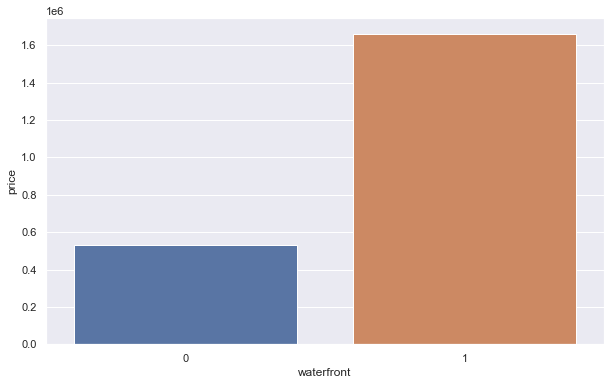

In [29]:
h1 = df3[['price','waterfront']].groupby('waterfront').mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(h1['waterfront'],h1['price'])

In [30]:
h1_percent = (h1.loc[1,'price'] - h1.loc[0,'price']) / h1.loc[0,'price']
print('H1 is True: properties with waterview are in the mean {0:.0%} more expensive'.format(h1_percent))

H1 is True: properties with waterview are in the mean 212% more expensive


### H2: Average price of properties constructed before 1955 would be less expensive

<AxesSubplot:xlabel='construction', ylabel='price'>

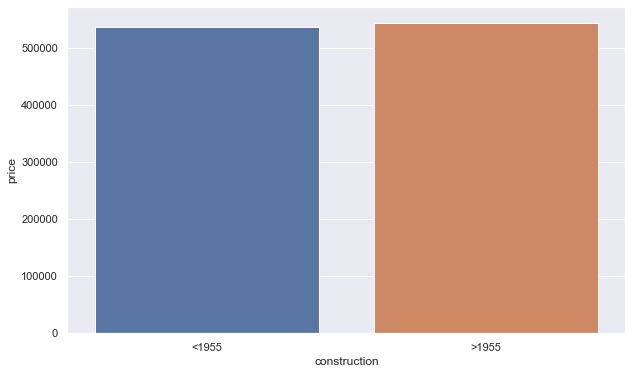

In [31]:
h2 = df3[['price','construction']].groupby('construction').mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(h2['construction'],h2['price'])

In [32]:
h2_percent = (h2.loc[1,'price'] - h2.loc[0,'price']) / h2.loc[1,'price']
print('H2 is False: properties constructed before 1955 are in the mean only {0:.0%} less expensive'.format(h2_percent))

H2 is False: properties constructed before 1955 are in the mean only 1% less expensive


### H3: Properties without basement would have larger square footage

<AxesSubplot:xlabel='basement', ylabel='sqft_lot'>

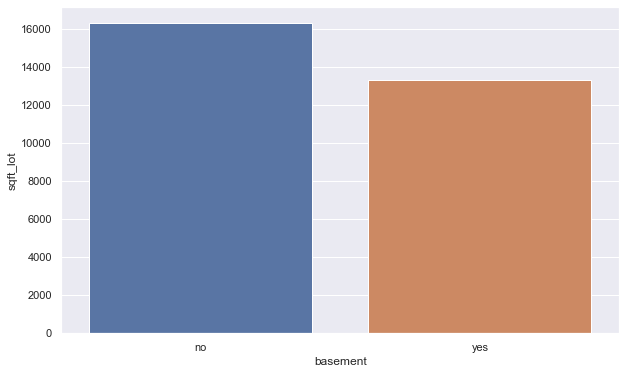

In [33]:
h3 = df3[['sqft_lot','basement']].groupby('basement').mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(h3['basement'],h3['sqft_lot'])

In [34]:
h3_percent = (h3.loc[0,'sqft_lot'] - h3.loc[1,'sqft_lot']) / h3.loc[1,'sqft_lot']
print('H3 is True: properties with no basement have square footage {0:.0%} larger'.format(h3_percent))

H3 is True: properties with no basement have square footage 23% larger


### H4: Prices would have rised up YoY (Year over Year)

<AxesSubplot:xlabel='year', ylabel='price'>

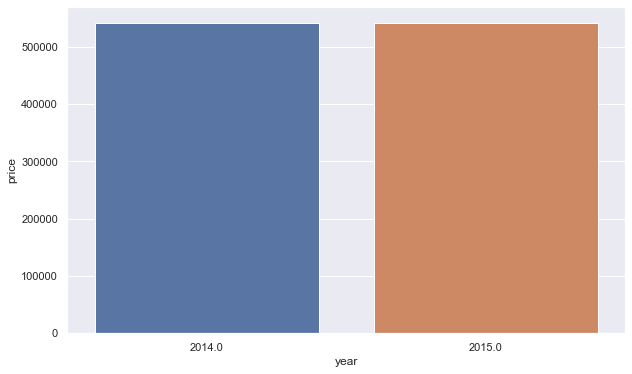

In [35]:
h4 = df3[['price','year']].groupby('year').mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(h4['year'],h4['price'])

In [36]:
h4_percent = (h4.loc[1,'price'] - h4.loc[0,'price']) / h4.loc[0,'price']
print('H4 is False: price growth from 2014 to 2015 was {0:.0%}'.format(h4_percent))

H4 is False: price growth from 2014 to 2015 was 0%


### H5: Properties with more bedrooms would be more expensive

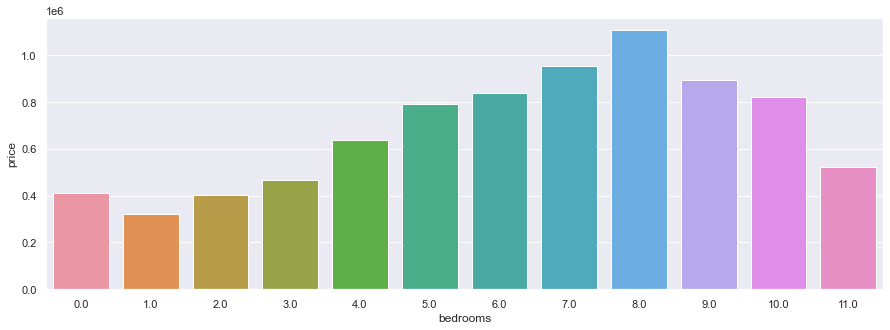

In [37]:
h5 = df3[['price','bedrooms']].groupby('bedrooms').mean().reset_index()

plt.figure(figsize=(15,5))
sns.barplot(h5['bedrooms'],h5['price'])

median = h5['bedrooms'].median()

bed_above = h5['price'][h5['bedrooms'] > median].mean()
bed_below = h5['price'][h5['bedrooms'] < median].mean()

In [38]:
h5_percent = (bed_above - bed_below) / bed_below
print('H5 is True: properties with more than 5 beds are {0:.0%} more expensive.'.format(h5_percent))

H5 is True: properties with more than 5 beds are 69% more expensive.


# 4.0 BUSINESS QUESTIONS & SOLUTIONS

In [39]:
df4 = df2.copy()
df4 = df4.dropna(axis=0)

## 4.1 Map showing where the houses are geographically located

In [40]:
df4['lat'] = df4['lat'].astype(float64)
df4['long'] = df4['long'].astype(float64)

In [41]:
df4['price'].fillna(0, inplace=True)

In [42]:
df4['waterfront'] = df4['waterfront'].apply(lambda x: "yes" if x=="1" else "no")

In [43]:
# Interactive buttons - widgets to control data

style = {'description_width': 'initial'}

# filter by waterfront
waterfront_bar = widgets.Dropdown(
    options=df4['waterfront'].unique().tolist(),
    value='no',
    description='Water View',
    disable=False)

# limit by price
price_limit = widgets.IntSlider(
    value=int(df4['price'].mean()),
    min=int(df4['price'].min()),
    max=int(df4['price'].max()),
    step=1,
    description='Maximum Price',
    disable=False,
    style={'description_width': 'initial'})

# limit living room squarefootage
livingroom_limit = widgets.IntSlider(
    value=int(df4['sqft_living'].mean()),
    min=df4['sqft_living'].min(),
    max=df4['sqft_living'].max(),
    step=1,
    description='Minimum Living Room Size',
    disable=False,
    style={'description_width': 'initial'})

# limit by bathrooms
bathroom_limit = widgets.IntSlider(
    value=df4['bathrooms'].min(),
    min=df4['bathrooms'].min(),
    max=df4['bathrooms'].max(),
    step=1,
    description='Minimum Number of Bathrooms',
    disable=False,
    style={'description_width': 'initial'})

# limit basement squarefootage
basement_limit = widgets.IntSlider(
    value=int(df4['sqft_basement'].mean()),
    min=df4['sqft_basement'].min(),
    max=df4['sqft_basement'].max(),
    step=1,
    description='Maximum Basement Size',
    disable=False,
    style={'description_width': 'initial'})

# limit property condition
condition_limit = widgets.IntSlider(
    value=df4['condition'].min(),
    min=df4['condition'].min(),
    max=df4['condition'].max(),
    step=1,
    description='Property Minimum Condition',
    disable=False,
    style={'description_width': 'initial'})

# limit construction year
construction_limit = widgets.IntSlider(
    value=int(df4['yr_built'].mean()),
    min=df4['yr_built'].min(),
    max=df4['yr_built'].max(),
    step=1,
    description='Year of Construction from',
    disable=False,
    style={'description_width': 'initial'})

In [44]:
def update_map (df4, waterfront, limit, livingroom_limit, bathroom_limit, basement_limit, condition_limit, construction_limit):
    
    houses = df4[(df4['waterfront'] == waterfront) &
                 (df4['price'] <= limit) & 
                 (df4['sqft_living'] >= livingroom_limit) &
                 (df4['bathrooms'] >= bathroom_limit) &
                 (df4['sqft_basement'] <= basement_limit) &
                 (df4['condition'] >= condition_limit) &
                 (df4['yr_built'] >= construction_limit)
                ][['id', 'lat', 'long', 'price', 'price_level', 'sqft_living', 'bathrooms', 'sqft_basement', 'condition', 'yr_built']].copy()
    
    fig = px.scatter_mapbox(houses, lat='lat', lon='long', color='price_level', size='price', 
                         color_continuous_scale=px.colors.named_colorscales(),
                         size_max=15,
                         zoom=10)
    fig.update_layout(mapbox_style='open-street-map')
    fig.update_layout(height=600, margin={'r':0, 't':0, 'l':0, 'b':0})
    fig.show()

In [45]:
widgets.interactive(update_map, df4=fixed(df4), 
                    waterfront=waterfront_bar, limit=price_limit, livingroom_limit=livingroom_limit, 
                    bathroom_limit=bathroom_limit, basement_limit=basement_limit, condition_limit=condition_limit, 
                    construction_limit=construction_limit)

# USE KEYBOARD "+" AND "-" TO ZOOM IN/OUT THE MAP
# EACH POINT INDICATES A PROPERTY AND ITS FEATURES

interactive(children=(Dropdown(description='Water View', options=('no', 'yes'), value='no'), IntSlider(value=5…

## 4.2 Dashboard with interactive charts

In [46]:
df5 = data.copy()

In [47]:
# change date format
df5['year'] = pd.to_datetime(data['date']).dt.strftime('%Y')
df5['date'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m-%d')
df5['year_week'] = pd.to_datetime(data['date']).dt.strftime('%Y-%U')

In [48]:
df5['id'] = df5['id'].astype(int64)
df5['yr_built'] = df5['yr_built'].astype(int64)
df5['yr_renovated'] = df5['yr_renovated'].astype(int64)

In [49]:
df5['yr_renovated'] = df5['yr_renovated'].replace(0, 1900)

In [50]:
# Interactive buttons - widgets to control data

# filter by waterfront
waterfront_box = widgets.Checkbox(
    value=False,
    options=df5.loc[:, 'waterfront'].unique().tolist(),
    description='Water View',
    disable=False,
    indent=False)

# property availability
date_limit = widgets.SelectionSlider(
    options=df5.loc[:, 'date'].sort_values().unique().tolist(),
    value = df5['date'].max(),
    description = "Availability",
    style={'description_width':'initial'},
    #disable=False,
    continuous_update=False,
    #orientation='horizontal',
    readout=True )

# renovation year
renovation_limit = widgets.SelectionSlider(
    options=df5.loc[:, 'yr_renovated'].sort_values().unique().tolist(),
    value = 2000,
    description = "Renovation Year from",
    style={'description_width':'initial'},
    disable=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True )

In [51]:
def update_dashboard( df5, date_limit, renovation_limit, waterfront_box ):
    
    # Filtering data
    df = df5[(df5['date'] <= date_limit) &
             (df5['yr_renovated'] >= renovation_limit) &
             (df5['waterfront'] == waterfront_box)][['id', 'price', 'date', 'yr_renovated', 'waterfront', 'year_week', 'year']].copy()
    
    fig = plt.figure(figsize=(24, 12))
    
    specs = gridspec.GridSpec( ncols=2, nrows=2, figure=fig )
    
    ax1 = fig.add_subplot( specs[0, :] ) # First row
    ax2 = fig.add_subplot( specs[1, 0] ) # Second Row First Column
    ax3 = fig.add_subplot( specs[1, 1] ) # Second Row Second Column  rows
    
    # first graph
    by_year = df[['price', 'year']].groupby( 'year').sum().reset_index()
#     ax1.bar( by_year['year'], by_year['id'] )
    sns.barplot(x='year', y='price', data=by_year, ax=ax1)
    
    # second graph
    by_day = df[['price', 'date']].groupby('date').mean().reset_index()
#     ax2.plot( by_day['date'], by_day['price'] )
#     ax2.set_title( 'title: Avg Price by Day' )
    sns.lineplot(x='date', y='price', data=by_day, ax=ax2)
    plt.xticks( rotation=90 );
    
    # third graph
    by_week_of_year = df[['price', 'year_week']].groupby('year_week').mean().reset_index()
#     ax3.bar( by_week_of_year['year_week'], by_week_of_year['price'] )
#     ax3.set_title( 'title: Avg Price by Week Of Year' )
#     plt.xticks( rotation=60 );
    sns.barplot(x='year_week', y='price', data=by_week_of_year, ax=ax3)
    plt.xticks( rotation=90 );

In [52]:
widgets.interactive(update_dashboard, df5=fixed(df5), 
                    date_limit=date_limit, 
                    renovation_limit=renovation_limit, 
                    waterfront_box=waterfront_box)

interactive(children=(SelectionSlider(continuous_update=False, description='Availability', index=371, options=…

## 4.3 Which properties should be bought by House Rocket and at what price?

In [53]:
# Group by zipcode and calculate median of price
df5 = df1[['zipcode','price']].groupby('zipcode').median().reset_index()
df5 = df5.rename(columns={'price': 'price_median'})

df6 = pd.merge(df1,df5,on='zipcode',how='inner')

# create column "status"
df6['status'] = 'NA'

for i in range(len(df6)):
    if (df6.loc[i,'price'] < df6.loc[i,'price_median']) & (int(df6.loc[i,'condition']) >= 3):
        df6.loc[i,'status'] = 'buy'
    else:
        df6.loc[i,'status'] = 'no buy'

In [54]:
df6['season'] = df6['date'].map(season_of_date)

In [55]:
# create a report showing only the requeriments for buying, sorted by price and condition 
buy_houses = df6[df6['status'] == 'buy'].sort_values(by=['condition','price'])

print('There are {} properties that fulfill the requirements for buying.'.format(len(buy_houses)))

There are 10579 properties that fulfill the requirements for buying.


In [56]:
buy_houses[['id','zipcode','price','price_median','condition']].sample(5)

,id,zipcode,price,price_median,condition
20116,9269260420,98011,436000.00,470000.00,3
12748,7229900005,98059,350000.00,435000.00,4
18577,2205700470,98006,650500.00,760184.50,3
9414,8645510230,98058,332000.00,335000.00,3
6408,5021900050,98040,832500.00,993750.00,4


### 4.4 After buying the selected properties, what is the best time to resell them and at which price?

In [57]:
# Group properties by zipcode and season
df7 = df6[['zipcode','season','price']].groupby(['zipcode','season']).median().reset_index()
df7 = df7.rename(columns={'price': 'price_season_median'})

df8 = pd.merge(buy_houses, df7, how='inner', on=['zipcode', 'season'])

Selling conditions:
* Buying price compared to the regian median and season to be considered

In [59]:
for i in range(len(df8)):
    if df8.loc[i, 'price'] <= df8.loc[i, 'price_season_median']:
         df8.loc[i, 'sale_price'] = df8.loc[i, 'price'] * 1.30
    elif df8.loc[i, 'price'] > df8.loc[i, 'price_season_median']:
         df8.loc[i, 'sale_price'] = df8.loc[i, 'price'] * 1.10
    else:
         pass

df8['profit'] = df8['sale_price'] - df8['price']

Report: Properties to be bought with suggestions of sale price and profit

In [60]:
df8[['id','zipcode','price','price_median','season','price_season_median','condition','sale_price','profit']].sample(5).T

,3712,9137,2158,2034,3486
id,3392100050,1186000150,4324200060,7229210060,7334501240
zipcode,98003,98122,98031,98058,98045
price,205000.00,563250.00,249000.00,299950.00,280000.00
price_median,267475.00,572000.00,288200.00,335000.00,399500.00
season,summer,winter,winter,autumn,spring
price_season_median,260875.00,526000.00,279000.00,322250.00,427000.00
condition,3,5,3,4,3
sale_price,266500.00,619575.00,323700.00,389935.00,364000.00
profit,61500.00,56325.00,74700.00,89985.00,84000.00


In [61]:
# Maximum Value Invested
df8['price'].sum()

4094212008.0

In [62]:
# Maximum Value Returned
df8['sale_price'].sum()

5287624648.2

In [63]:
# Maximum Expected Profit:
df8['profit'].sum()

1193412640.2

### 4.5 Insights - Selected Properties

In [64]:
# df8['waterfront'] = df8['waterfront'].astype(int64)
df8['waterfront'] = df8['waterfront'].apply(lambda x: 1 if x != '0' else 'no waterfront')
df8['renovated'] = df8['yr_renovated'].apply(lambda x: 1 if x != '0' else '0')
df8['basement'] = df8['sqft_basement'].apply(lambda x: 'no basement' if x == 0 else 1)
df8['renovated'] = df8['yr_renovated'].apply(lambda x: 'no' if x == 0 else 'yes')
df8['yr_built'] = df8['yr_built'].astype(int64)
df8['construction'] = df8['yr_built'].apply(lambda x: '<1955' if x <= 1955 else '>1955')
df8['describe_condition'] = df8['condition'].apply(lambda x: 'too bad' if x == 1 else
                                                             'bad'     if x == 2 else
                                                             'median'  if x == 3 else
                                                             'good'    if x == 4 else
                                                             'excellent')

In [170]:
# Seleção dos atributos cujo array é analisável
df9 = df8[['zipcode','bedrooms','bathrooms','floors','season',
           'renovated','describe_condition','waterfront','basement','grade','construction','profit']]

Insights - Selected Properties
The most profitable properties have "zipcode" as "98006"
The most profitable properties have "bedrooms" as "3"
The most profitable properties have "bathrooms" as "1.0"
The most profitable properties have "floors" as "1.0"
The most profitable properties have "season" as "spring"
The most profitable properties have "renovated" as "yes"
The most profitable properties have "describe_condition" as "excellent"
The most profitable properties have "waterfront" as "1"
The most profitable properties have "basement" as "no basement"
The most profitable properties have "grade" as "7"
The most profitable properties have "construction" as ">1955"


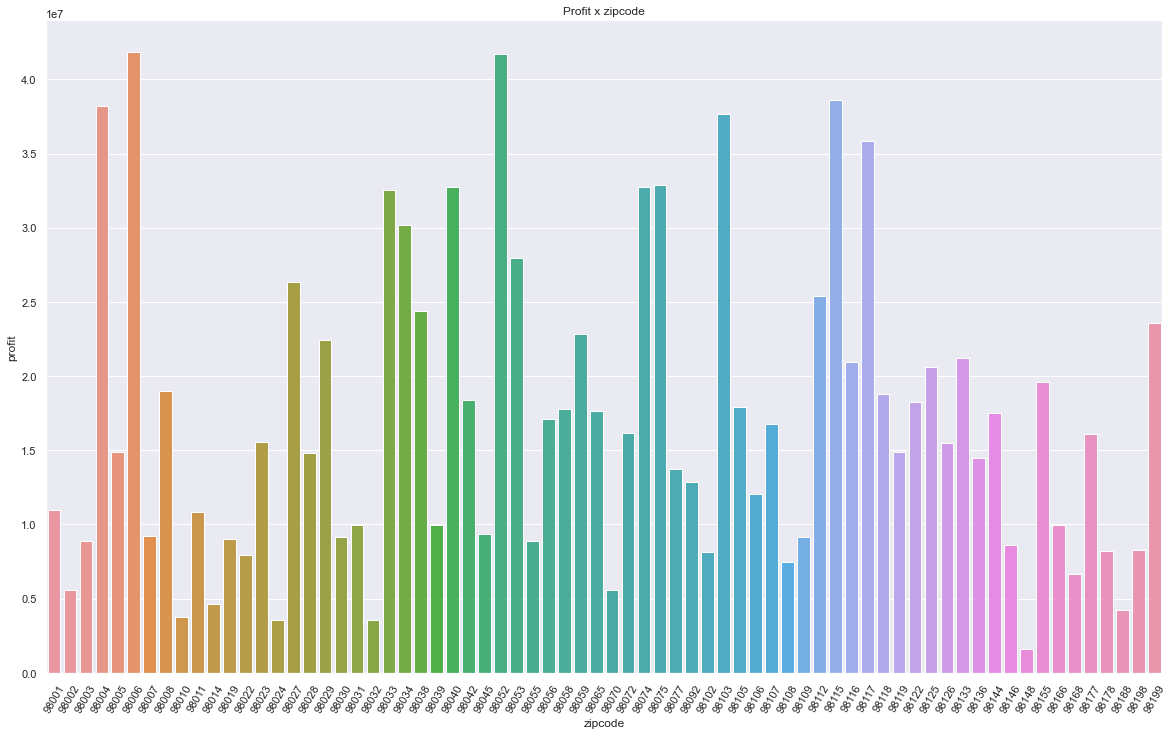

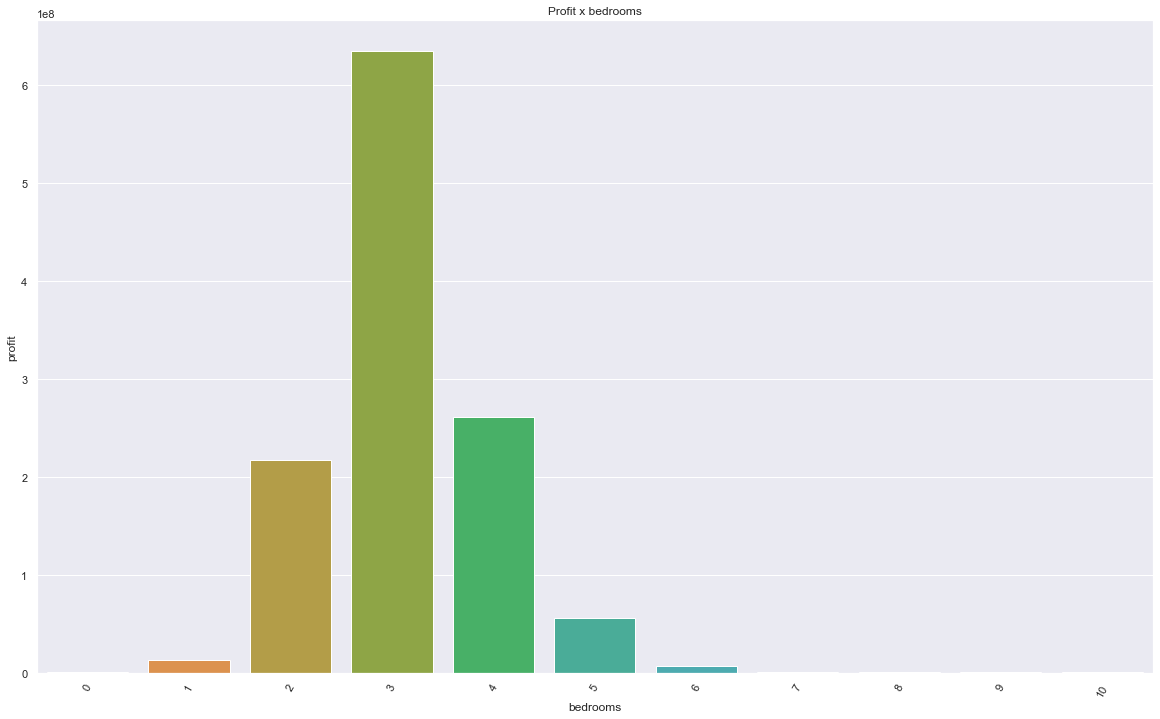

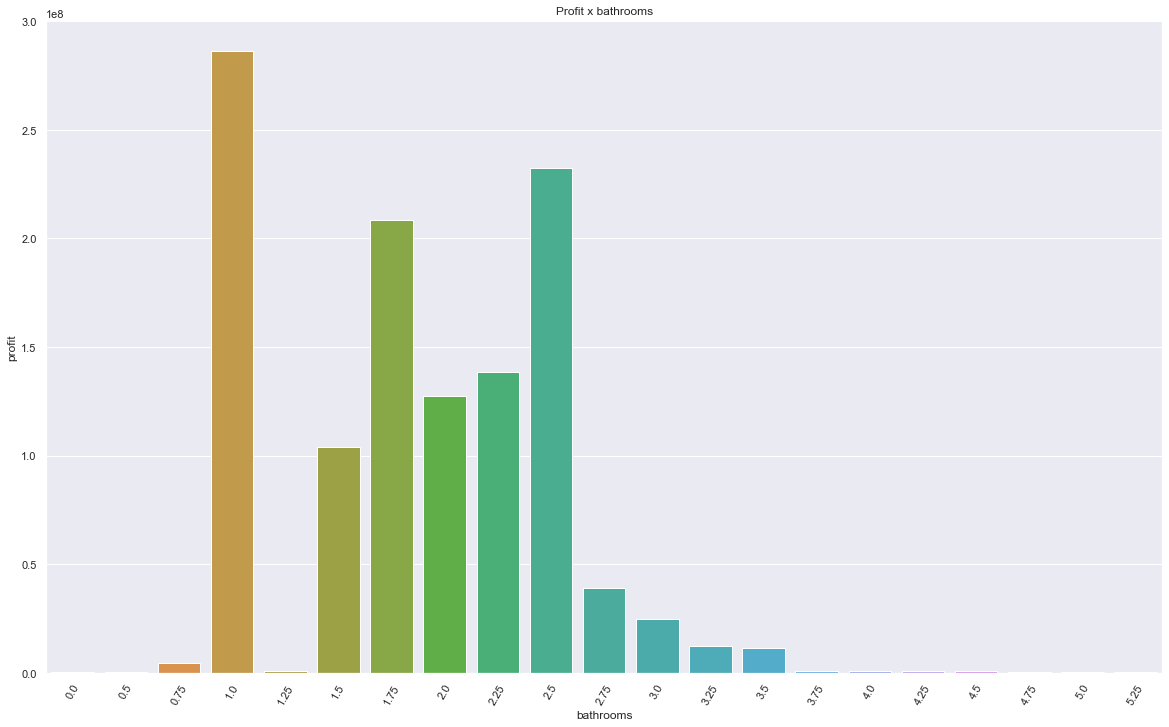

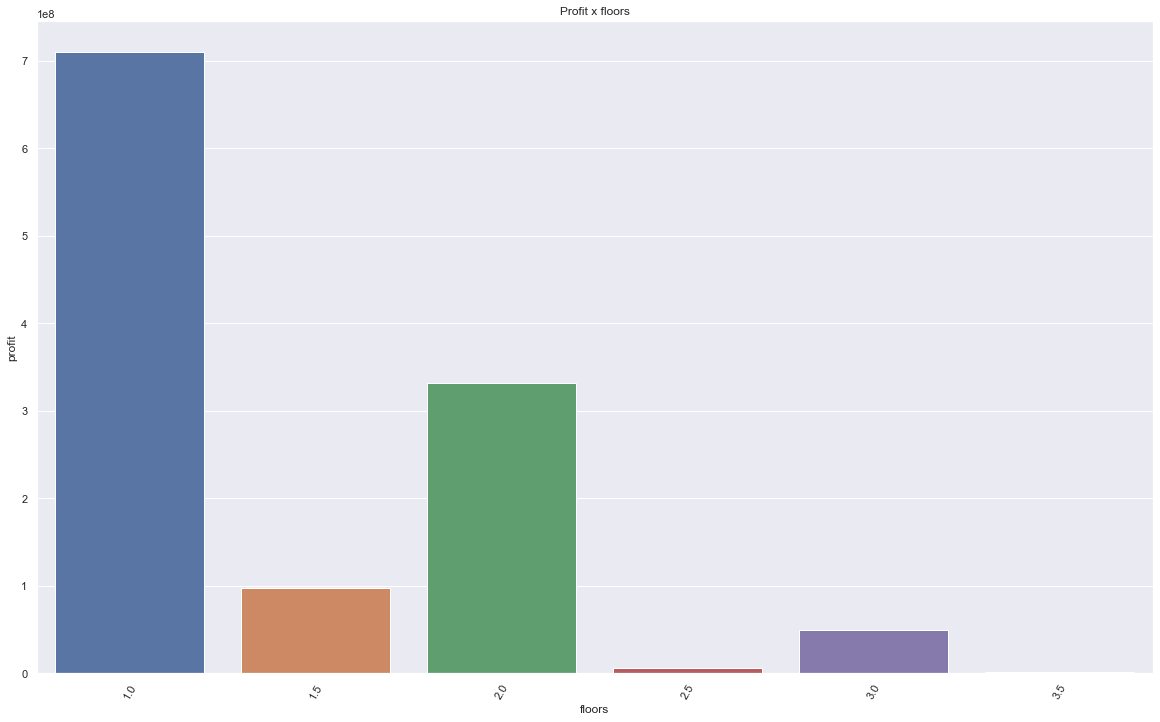

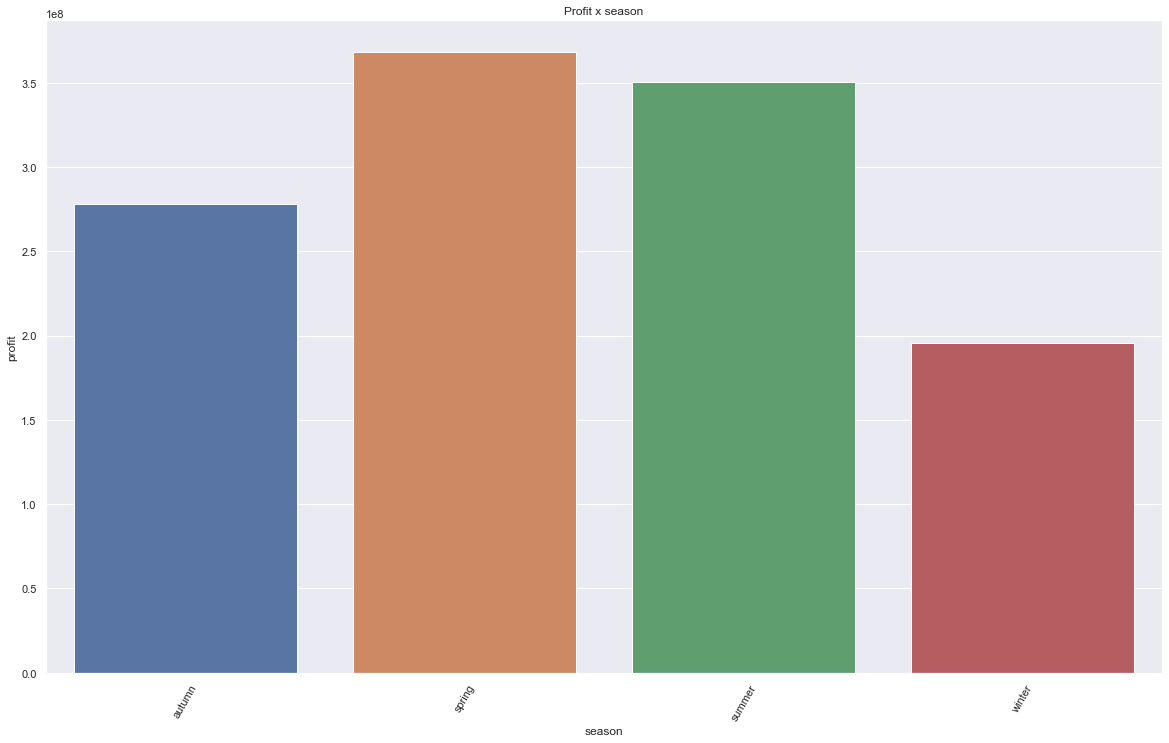

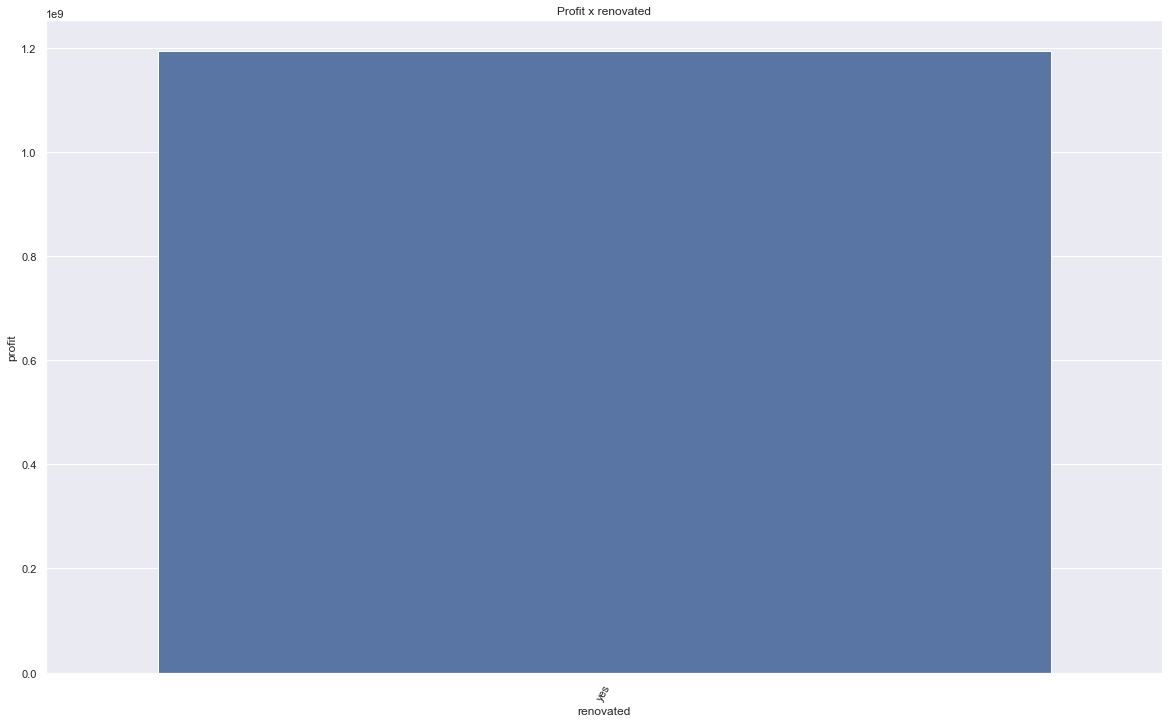

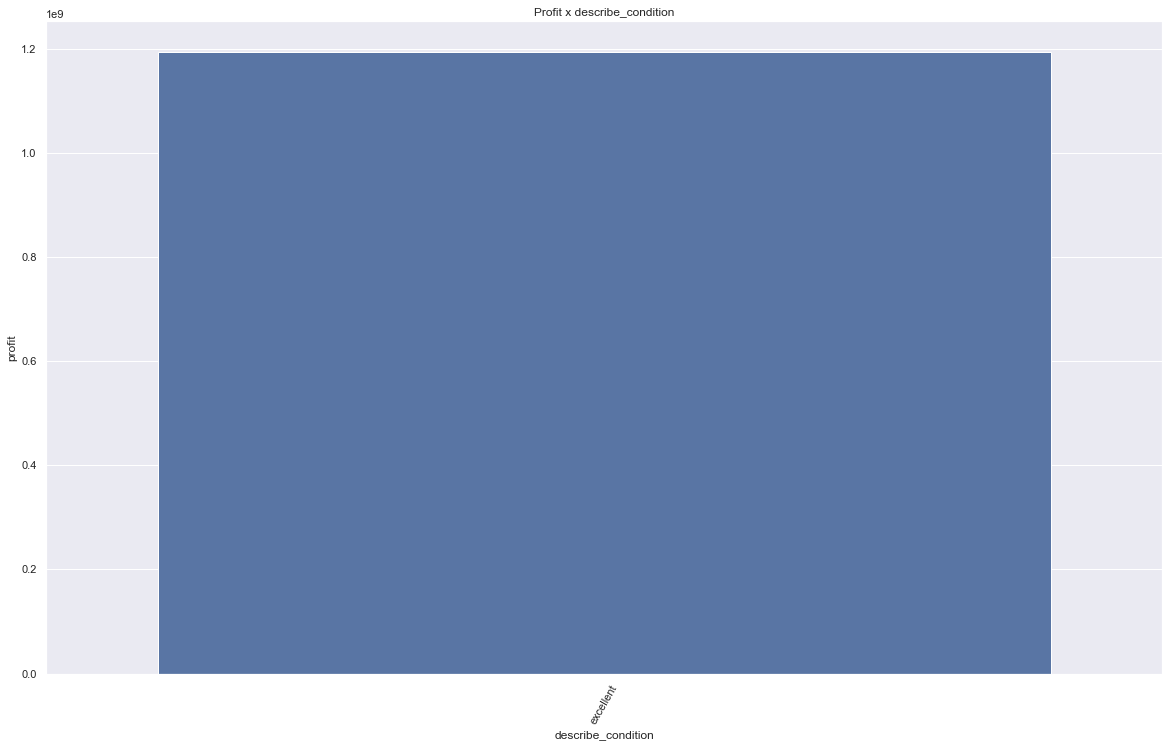

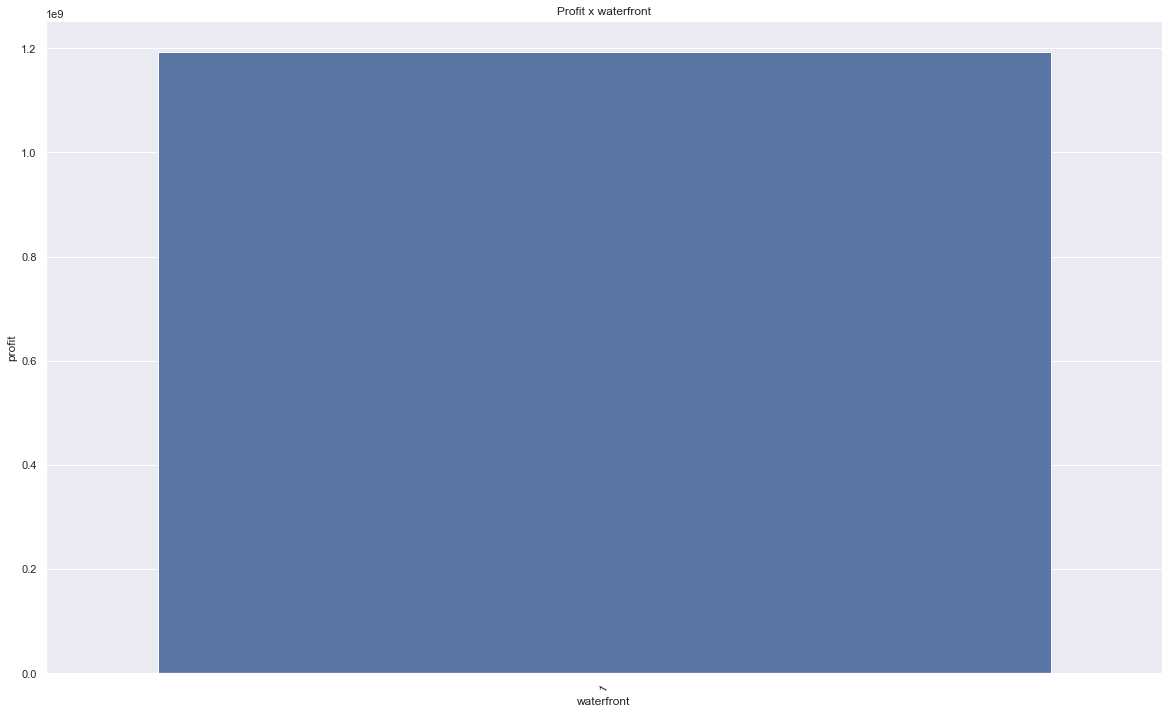

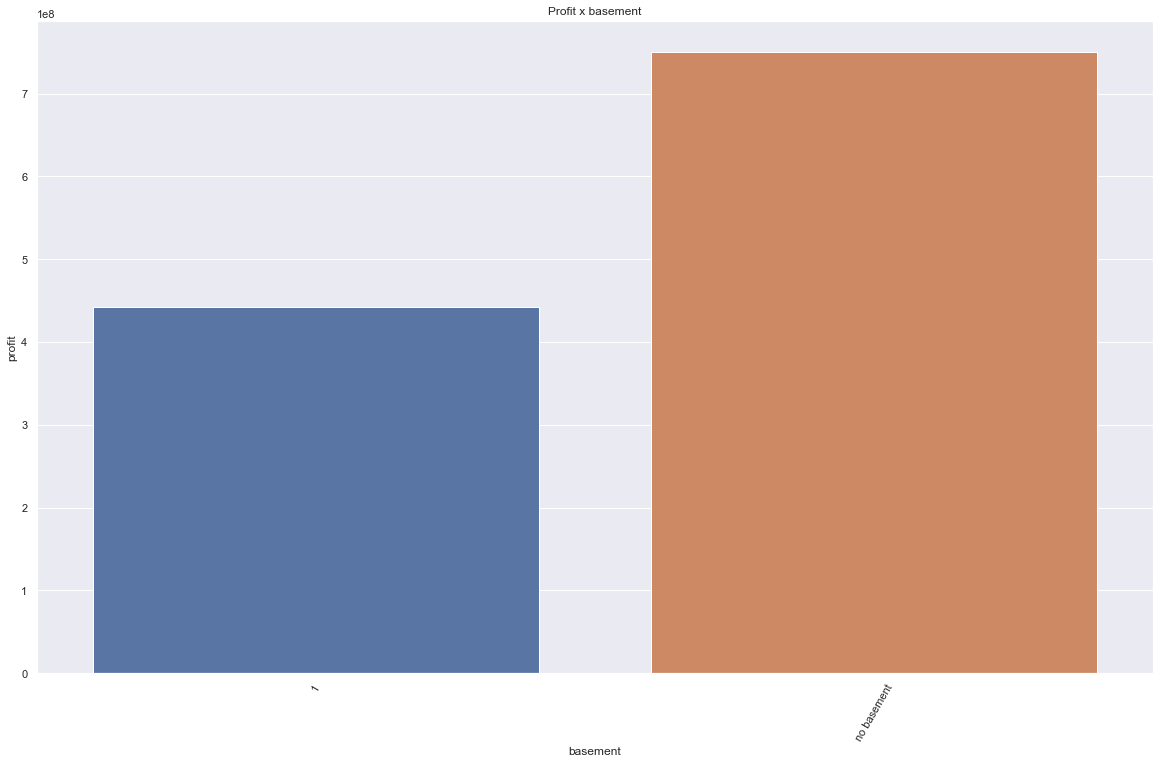

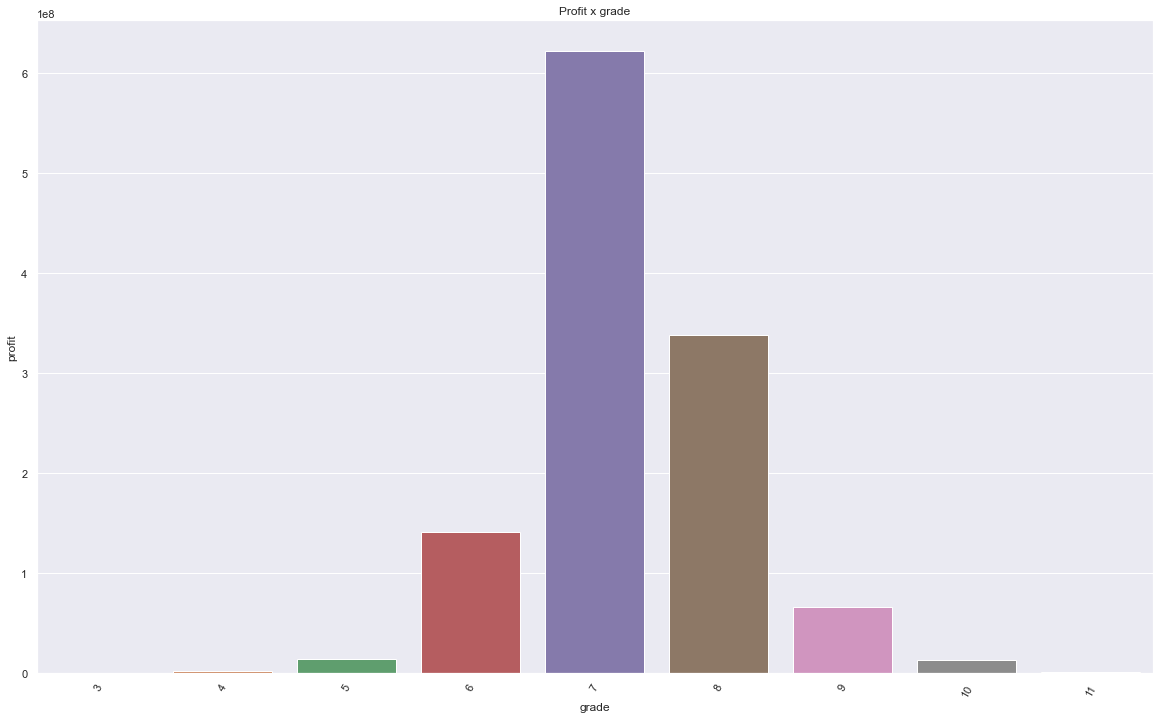

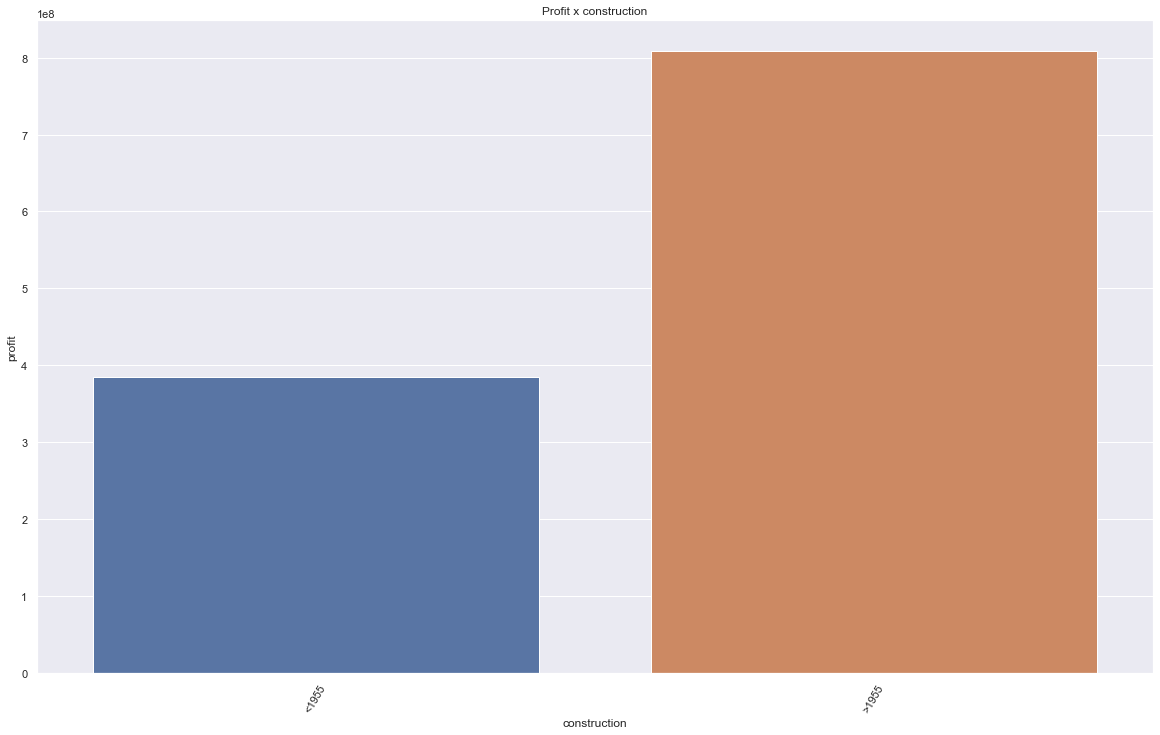

In [175]:
print("Insights - Selected Properties")
conditions = []
for i in df9.columns:
    if i != 'profit':
        ins = df9[['profit',i]].groupby(i).sum().reset_index()
        plt.figure(figsize=(20,12))
        sns.barplot(ins[i],ins['profit']).set(title='Profit x {}'.format(i))
        plt.xticks(rotation=60);
        ins2 = ins[ins['profit'] == ins['profit'].max()]
        conditions.append(ins2.iloc[0,0])
        print('The most profitable properties have "{}" as "{}"'.format(i, ins2.iloc[0,0]))